In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..', 'module'))

In [3]:
import wiki

path_base = '/Users/harangju/Developer/data/wiki/dumps/'
name_xml = 'enwiki-20190801-pages-articles-multistream.xml.bz2'
name_index = 'enwiki-20190801-pages-articles-multistream-index.txt.bz2'
path_xml = path_base + name_xml
path_index = path_base + name_index
dump = wiki.Dump(path_xml, path_index)

In [4]:
topic = 'evolutionary biology'
%time dump.load_page('Index of {} articles'.format(topic))
links = dump.links
dump.links[:5]

Dump: Loading index...
Dump: Loaded.
CPU times: user 1min 17s, sys: 2.05 s, total: 1min 19s
Wall time: 1min 20s


['File:charles Darwin by Julia Margaret Cameron 2.jpg',
 'Charles Darwin',
 'Evolutionary biology',
 'The Origin of Species',
 'Abiogenesis']

#### Test network generation

In [30]:
import pickle
import gensim.utils as gu

path_save = '/Users/harangju/Developer/data/wiki/models/'
tfidf = gu.SaveLoad.load(path_save + 'tfidf.model')
dct = pickle.load(open(path_save + 'dict.model','rb'))

In [88]:
net = wiki.Net()
net.build_graph(name=topic, dump=dump, nodes=[str(l) for l in links],
                model=tfidf, dct=dct)

wiki.Net: traversing Wikipedia...
wiki.Net: depth = 0
wiki.Net: len(queue) = 160
wiki.Net: depth = 1
wiki.Net: removing isolates...
wiki.Net: adding years...
wiki.Net: filling empty years...
wiki.Net: calculating weights...
wiki.Net: computing core-periphery...
wiki.Net: computing communities...
wiki.Net: computing cores within communities...


In [93]:
[len(links), len(net.graph.nodes)]
# [291, 265] with redirects
# [291, 234] without

[291, 265]

In [94]:
net.graph.graph

{'name': 'evolutionary biology',
 'num_years': 162,
 'tfidf': <2080851x265 sparse matrix of type '<class 'numpy.float64'>'
 	with 253947 stored elements in Compressed Sparse Column format>,
 'coreness_be': 0.7845415242880858,
 'coreness_rb': 371.15664031551466,
 'modularity': 0.26006018498783096,
 'community_coreness_be': {0: 0.45422226003541477,
  1: 0.6516582248566232,
  2: 0.5463887464258219,
  3: 0.5489987317401552,
  4: 0.4529930348224899,
  5: 0.4817648365219904,
  6: 0.3226592055775046,
  7: 0.4363946077080396,
  8: 0.5261546377021571,
  9: 0.4313596132176271,
  10: 0.3767651111568251,
  11: 0.5135908413718031,
  12: 0.6379308792362511,
  13: 0.49311503022753006,
  14: 0.4450362859622329,
  15: 0.5473337965162792,
  16: 0.701458266881393,
  17: 0.2823447323932047,
  18: 0.2918330493353162,
  19: 0.41730826232683366,
  20: 0.41832292071251853,
  21: 0.604077692033959,
  22: 0.2807682586635488,
  23: 0.5,
  24: 0.5190804142459637,
  25: 0.33333333333333337,
  26: 0.333333333333333

In [91]:
net.graph.nodes['Darwinism']

{'year': 1800,
 'core_be': 1,
 'core_rb': 0.9292452830188679,
 'community': 18,
 'community_core_be': 1,
 'community_core_rb': 0.2}

In [83]:
[n for n in net.graph.nodes][:5]

['The Voyage of the Beagle',
 'Charles Darwin',
 'Charles Lyell',
 'Thomas Henry Huxley',
 'Evolution']

In [84]:
[y for y in net.years][:5]

[-9000, -3500, -1900, -600, -500]

In [85]:
net._numbered = None
[n for n in net.numbered.nodes][:5]

[0, 1, 36, 14, 15]

#### Test network saving & loading

In [33]:
net.save_graph(topic)

In [34]:
new_net = wiki.Net()
new_net.load_graph(topic)
len(new_net.graph.nodes)

265

In [35]:
new_net.graph.graph

{'name': 'evolutionary biology',
 'num_years': 162,
 'tfidf': <2080851x265 sparse matrix of type '<class 'numpy.float64'>'
 	with 253947 stored elements in Compressed Sparse Column format>,
 'coreness_be': [0.0669858348599072],
 'coreness_rb': [371.15664031551466],
 'modularity': 0.26006018498783096}

#### Test weighting with tf-idf model

In [86]:
net.graph['Evolution']

AtlasView({'The Voyage of the Beagle': {'weight': 0.2712892805463564}, 'Charles Darwin': {'weight': 0.4313447568679566}, 'Thomas Henry Huxley': {'weight': 0.2997149409806503}, 'Phylogenetics': {'weight': 0.3081110630771805}, 'Human evolution': {'weight': 0.4969458591576819}, 'Evolutionary biology': {'weight': 0.4400523916182571}, 'Common descent': {'weight': 0.5480997893873277}, 'Paleontology': {'weight': 0.571378381990398}, 'Evolutionary developmental biology': {'weight': 0.5305819256346003}, 'The Origin of Species': {'weight': 0.5765181173462256}, 'History of evolutionary thought': {'weight': 0.72609538318932}, 'Adaptation': {'weight': 0.6818558586652332}, 'Ernst Mayr': {'weight': 0.3972277774230849}, 'Homology (biology)': {'weight': 0.4042887057442101}, 'Galápagos Islands': {'weight': 0.307717245640983}, 'Group selection': {'weight': 0.5513371852065686}, 'Domestication': {'weight': 0.4453884216606581}, 'Transitional fossil': {'weight': 0.47899815281482416}, 'Punctuated equilibrium':

In [40]:
net.graph['Transposon']

AtlasView({'List of biology topics': {'weight': 0.1966936076996275}})

#### Test coreness

Borgatti-Everett

In [73]:
%time wiki.Net.assign_core_periphery(net.graph)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000       -183.90     8.00%     7.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000       -183.52     2.00%     1.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000       -182.72     4.00%     3.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000       -182.61     4.00%     4.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000       -183.11     3.00%     3.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000       -183.43     4.00%     2.00%     0:00:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000       -182.16    10.00%    10.00%     0:00:02     0:00:00 Temperature 

CPU times: user 19.6 s, sys: 889 ms, total: 20.4 s
Wall time: 20.2 s


In [74]:
net.graph.graph['coreness_be']

0.7845415242880858

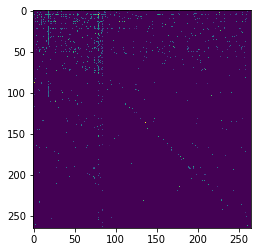

In [75]:
import networkx as nx
import matplotlib.pyplot as plt

matrix = nx.convert_matrix.to_numpy_array(net.graph,
                                          nodelist=[n for n in net.graph.nodes
                                                    if net.graph.nodes[n]['core_be']] +
                                                   [n for n in net.graph.nodes
                                                    if not net.graph.nodes[n]['core_be']])
plt.imshow(matrix)
plt.show()

/Users/harangju/anaconda3/envs/wikinet/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/harangju/anaconda3/envs/wikinet/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


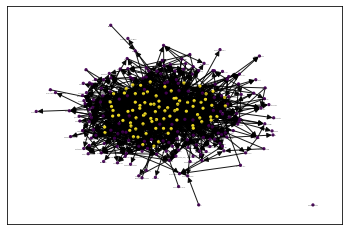

In [76]:
import networkx as nx
pos = nx.drawing.nx_agraph.graphviz_layout(net.graph, prog='neato')
nx.drawing.nx_pylab.draw_networkx(net.graph,
                                  pos,
                                  font_size=0,
                                  alpha=0.9,
                                  node_size=5,
                                  node_color=[net.graph.nodes[n]['core_be']
                                              for n in net.graph.nodes])

Rombach

In [77]:
net.graph.graph['coreness_rb']

[183.90095514534235]

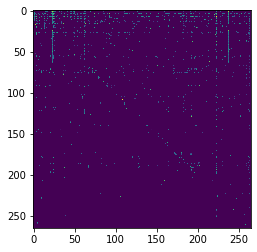

In [78]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = list(nx.get_node_attributes(net.graph, 'core_rb').items())
nodes = nodes.sort(key=lambda x: x[1])
matrix = nx.convert_matrix.to_numpy_array(net.graph, nodelist=nodes)
plt.imshow(matrix)
plt.show()

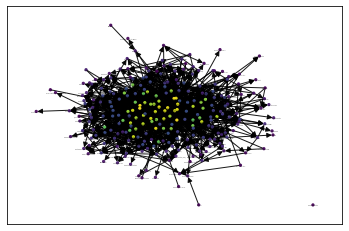

In [71]:
import networkx as nx
pos = nx.drawing.nx_agraph.graphviz_layout(net.graph, prog='neato')
nx.drawing.nx_pylab.draw_networkx(net.graph,
                                  pos,
                                  font_size=0,
                                  alpha=0.9,
                                  node_size=5,
                                  node_color=[net.graph.nodes[n]['core_rb']
                                              for n in net.graph.nodes])

#### Test community structure

In [47]:
net.graph.graph['modularity']

0.26006018498783096

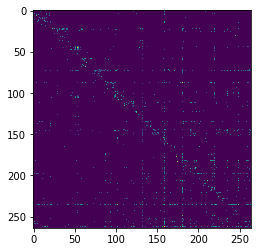

In [48]:
import matplotlib.pyplot as plt

num_communities = max([net.graph.nodes[n]['community'] for n in net.graph.nodes])
nodelist = [[n for n in net.graph.nodes if net.graph.nodes[n]['community']==i]
            for i in range(num_communities)]
nodelist = [n for ns in nodelist for n in ns]
matrix = nx.convert_matrix.to_numpy_array(net.graph,
                                          nodelist=nodelist)
plt.imshow(matrix)

#### Test clique to barcodes

In [49]:
net._cliques = None
%time net.cliques[:4]
%time net.cliques[:4]

CPU times: user 19.3 ms, sys: 1.22 ms, total: 20.5 ms
Wall time: 19.9 ms
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


[[0], [1], [36], [14]]

In [50]:
net.nodes_for_year[1800]

[3,
 5,
 10,
 22,
 23,
 32,
 50,
 63,
 70,
 80,
 105,
 115,
 134,
 152,
 183,
 188,
 237,
 240,
 242,
 258]

In [51]:
%time net.filtration

CPU times: user 3.52 s, sys: 3.93 ms, total: 3.53 s
Wall time: 3.53 s


Filtration with 8797 simplices

In [52]:
%time net.persistence

CPU times: user 5.99 ms, sys: 152 µs, total: 6.14 ms
Wall time: 6.13 ms


Reduced matrix with 8797 columns

In [53]:
import pandas as pd
pd.options.display.max_rows = 12

In [54]:
net._barcodes = None
%time net.barcodes
%time net.barcodes

wiki.Net: computing barcodes... (skip negatives)
wiki.Net: barcode 8788/8797
CPU times: user 2.89 s, sys: 619 ms, total: 3.51 s
Wall time: 3.85 s
CPU times: user 14 µs, sys: 5 µs, total: 19 µs
Wall time: 21.7 µs


,dim,birth,death,lifetime,birth simplex,death simplex,birth nodes,death nodes,homology nodes
0,0,-9000,inf,inf,[Domestication],[],[Domestication],[],[]
1,0,-3500,-3500.0,0.0,[Domestication of the horse],"[Domestication, Domestication of the horse]",[Domestication of the horse],[Domestication of the horse],"[Domestication of the horse, Domestication]"
2,0,-1900,1600.0,3500.0,[Language],"[Evolution, Domestication]",[Language],[Evolution],"[Language, Domestication]"
3,0,-600,-600.0,0.0,[Origin of language],"[Origin of language, Language]",[Origin of language],[Origin of language],"[Language, Origin of language]"
4,0,-500,1600.0,2100.0,[Phylogenetics],"[Evolution, Human evolution]",[Phylogenetics],[Evolution],"[Phylogenetics, Origin of language]"
...,...,...,...,...,...,...,...,...,...
4462,6,1915,1915.0,0.0,"[Natural selection, Evolutionary biology, Hist...","[Evolution, Natural selection, Evolutionary bi...",[J. B. S. Haldane],[J. B. S. Haldane],"[History of evolutionary thought, On The Origi..."
4463,6,1915,1915.0,0.0,"[Modern synthesis (20th century), Evolutionary...","[Evolution, Modern synthesis (20th century), E...",[J. B. S. Haldane],[J. B. S. Haldane],"[History of evolutionary thought, Evolution, E..."
4464,6,1915,1915.0,0.0,"[Modern synthesis (20th century), Evolutionary...","[Evolution, Modern synthesis (20th century), E...",[J. B. S. Haldane],[J. B. S. Haldane],"[History of evolutionary thought, On The Origi..."
4465,7,1915,1915.0,0.0,"[Natural selection, Modern synthesis (20th cen...","[Evolution, Natural selection, Modern synthesi...",[J. B. S. Haldane],[J. B. S. Haldane],"[History of evolutionary thought, Evolution, E..."


In [55]:
net.barcodes[net.barcodes.lifetime!=0]

,dim,birth,death,lifetime,birth simplex,death simplex,birth nodes,death nodes,homology nodes
0,0,-9000,inf,inf,[Domestication],[],[Domestication],[],[]
2,0,-1900,1600.0,3500.0,[Language],"[Evolution, Domestication]",[Language],[Evolution],"[Language, Domestication]"
4,0,-500,1600.0,2100.0,[Phylogenetics],"[Evolution, Human evolution]",[Phylogenetics],[Evolution],"[Phylogenetics, Origin of language]"
5,0,-458,1600.0,2058.0,[Heredity],"[Evolution, Heredity]",[Heredity],[Evolution],"[Phylogenetics, Heredity]"
6,0,-350,1600.0,1950.0,[Anti-predator adaptation],"[Evolution, Anti-predator adaptation]",[Anti-predator adaptation],[Evolution],"[Phylogenetics, Anti-predator adaptation]"
...,...,...,...,...,...,...,...,...,...
2764,2,2020,inf,inf,"[Systematics, Phylogenetic tree, Evolutionary ...",[],[Systematics],[],[]
2765,2,2020,inf,inf,"[Systematics, History of speciation, List of b...",[],[Systematics],[],[]
2767,2,2020,inf,inf,"[Systematics, Joe Felsenstein, Molecular syste...",[],[Systematics],[],[]
2770,2,2020,inf,inf,"[History of evolutionary thought, Jean-baptist...",[],[Jean-baptiste Lamarck],[],[]
